# Dataset generator

```python
C = Circle
E = Ellipse
M = Moon
S = Star
F = Filament
```

## Train datasets

In [47]:
import deeptrack as dt
import numpy as np
from deeptrack.scatterers import Scatterer
from deeptrack.backend.units import ConversionTable
from deeptrack.types import PropertyLike
from deeptrack import units as u

class Square(Scatterer):
    """Generates a simple square scatterer.

    Parameters
    ----------
    side_length : float
        Length of the sides of the square in meters.
    rotation : float
        Orientation angle of the square in the camera plane in radians.
    position : array_like[float, float (, float)]
        The position of the particle. Third index is optional,
        and represents the position in the direction normal to the
        camera plane.
    z : float
        The position in the direction normal to the
        camera plane. Used if `position` is of length 2.
    value : float
        A default value of the characteristic of the particle. Used by
        optics unless a more direct property is set: (eg. `refractive_index`
        for `Brightfield` and `intensity` for `Fluorescence`).
    upsample : int
        Upsamples the calculations of the pixel occupancy fraction.
    """

    __conversion_table__ = ConversionTable(
        side_length=(u.meter, u.meter),
        rotation=(u.radian, u.radian),
    )

    def __init__(
        self,
        side_length: PropertyLike[float] = 1e-6,
        rotation: PropertyLike[float] = 0,
        **kwargs,
    ):
        super().__init__(
            side_length=side_length, rotation=rotation, **kwargs
        )

    def _process_properties(self, properties: dict) -> dict:
        """Preprocess the input to the method .get()

        Ensures that the side length is correctly processed.
        """
        properties = super()._process_properties(properties)

        # Ensure side_length is a single value
        side_length = np.array(properties["side_length"])
        if side_length.ndim == 0:
            side_length = np.array([properties["side_length"], properties["side_length"]])
        properties["side_length"] = side_length

        return properties

    def get(self, *ignore, side_length, rotation, voxel_size, **kwargs):

        # Create a grid to calculate on
        side = side_length[0]
        half_side = side / 2
        max_side = half_side / np.cos(np.pi / 4)
        ceil = int(np.ceil(max_side / np.min(voxel_size[:2])))
        Y, X = np.meshgrid(
            np.arange(-ceil, ceil + 1) * voxel_size[1],
            np.arange(-ceil, ceil + 1) * voxel_size[0],
        )

        # Rotate the grid if needed
        if rotation != 0:
            Xt = X * np.cos(-rotation) + Y * np.sin(-rotation)
            Yt = -X * np.sin(-rotation) + Y * np.cos(-rotation)
            X = Xt
            Y = Yt

        # Evaluate square
        mask = (np.abs(X) <= half_side) & (np.abs(Y) <= half_side)
        mask = mask.astype(float)
        mask = np.expand_dims(mask, axis=-1)
        return mask


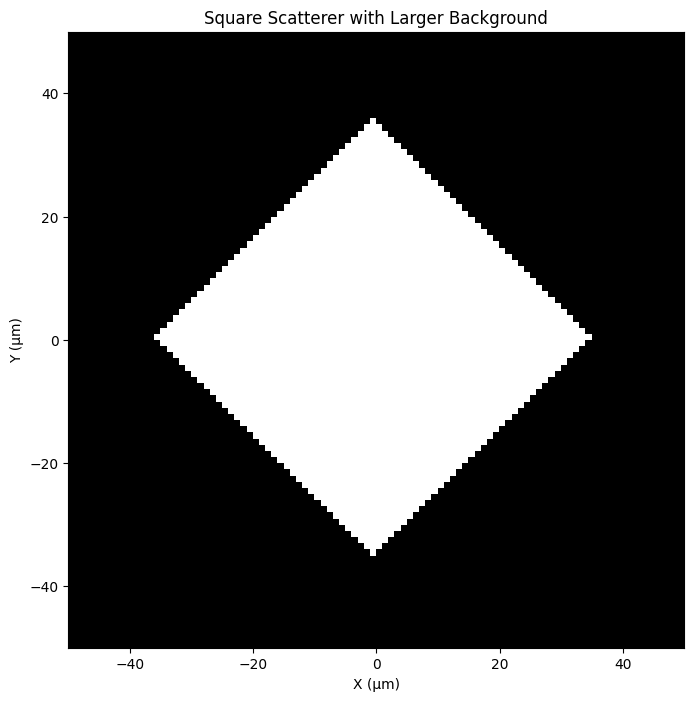

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from deeptrack import units as u
from deeptrack.image import Image

# Create a Square instance
particle_Sq = Square(
    side_length=50 * u.um,
    position=(0, 0),
    rotation=np.deg2rad(45),
)

# Create an Image with the Square
image = Image(particle_Sq)


# Generate the image
result = image.resolve()

# Create a larger background
background_size = 100
larger_result = np.zeros((background_size, background_size, 1))

# Calculate the position to place the square in the center
start_x = (background_size - result.shape[0]) // 2
start_y = (background_size - result.shape[1]) // 2

# Place the square in the center of the larger background
larger_result[start_x:start_x+result.shape[0], start_y:start_y+result.shape[1], 0] = result[:,:,0]

# Plot the result
plt.figure(figsize=(8, 8))
# Convert voxel_size to a plain number in micrometers
extent_um = np.array([-background_size/2, background_size/2, -background_size/2, background_size/2]) * voxel_size_um
plt.imshow(larger_result[:,:,0], cmap='gray', extent=extent_um)
plt.title('Square Scatterer with Larger Background')
plt.xlabel('X (µm)')
plt.ylabel('Y (µm)')
plt.show()

In [74]:
import deeptrack as dt 
from numpy.random import uniform
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import ConcatDataset
import torch

image_size = 32

particle_Sq = Square(
            intensity = 5.0,
            position_unit="pixel",
            position=lambda: uniform(image_size / 2 - 5, image_size / 2 + 5, size=2),
            side_length= 15*dt.units.pixel,
            rotation=lambda: np.random.uniform(0, 2 * np.pi),   
        )

optics = dt.Fluorescence(output_region=(0, 0, image_size, image_size), NA=2)

simulation_Sq = (
    optics(particle_Sq) 
    >> dt.NormalizeMinMax(0, 1)
    >> dt.Gaussian(sigma=0.1)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

### 1 particle

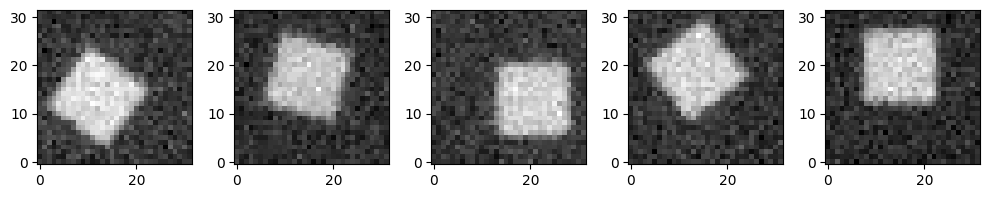

In [75]:
# Square
train_dataset_Sq = dt.pytorch.Dataset(simulation_Sq & [0], length=100)

plt.figure(figsize=(10, 2))
for i in range(5):
	image, lab  = train_dataset_Sq[int(i)]
	plt.subplot(1, 5, i+1)
	plt.imshow(image[0], cmap="gray", origin="lower")
plt.tight_layout()
plt.show()